## NIH COMmunity:  Wearable model training and evaluation script

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_auc_score, roc_curve, classification_report
from xgboost import XGBClassifier

from utils import * ### need utils.py in the same folder as this notebook
from time import time

idx = pd.IndexSlice
pd.set_option('max.rows', 100)
pd.set_option('max.columns', 300)
pd.set_option('mode.chained_assignment', 'raise')
pd.set_option('display.float_format', lambda x: '%.4f' % x) #supress scientific notation

### Package versions:

* pandas 1.1.1
* numpy 1.19.1
* sklearn 0.23.2
* seaborn 0.10.1
* matplotlib 3.3.1
* xgboost 1.2.0

### Generate synthetic data

* Using `train`, `val`, `test` splits of 150, 30, 30 participants, respectively
* Using ILI types - `Flu` (2) and `Covid` (3) -- these differ in activity levels for 4 daily heart-rate (HR) related features:
    * Maximum HR when not moving
    * Resting HR
    * HR std. dev.
    * HR 50 percentile
* These 4 features are shifted 4 days back -- providing 5 days of features (including today) to make a prediction for today's ILI status
* Creates 43 days of data around a single ILI onset event
* Days -28 to -22, -7 to 0, and 8 to 14 are buffer days -- labeled `-1` for training
* Days -21 to -8 are "healthy" days -- labeled `0` for training
* Days 1 to 7 are "sick" days -- labeled `1` for training

In [ ]:
rnd = np.random.RandomState(1493)
max_num = 1000000
df_activity = pd.concat([generate_normalized_hr_sample(i, 'train', 3) for i in rnd.choice(np.arange(1,max_num),150)]
                     + [generate_normalized_hr_sample(i, 'val',3) for i in rnd.choice(np.arange(1,max_num),30)]
                     + [generate_normalized_hr_sample(i, 'test',3) for i in rnd.choice(np.arange(1,max_num),30)]
                     +  [generate_normalized_hr_sample(i, 'train', 2) for i in rnd.choice(np.arange(1,max_num),150)]
                     + [generate_normalized_hr_sample(i, 'val',2) for i in rnd.choice(np.arange(1,max_num),30)]
                     + [generate_normalized_hr_sample(i, 'test',2) for i in rnd.choice(np.arange(1,max_num),30)]
                    )
print(df_activity.shape)
print('N =', count_unique_index(df_activity))
describe_datetimeindex(df_activity)

(18060, 24)
N = 420
Out[20]: count 18060
mean 2020-04-04 20:34:17.142857216
min 2020-01-04 00:00:00
25% 2020-02-28 00:00:00
50% 2020-04-05 00:00:00
75% 2020-05-09 00:00:00
max 2020-07-11 00:00:00
Name: dt, dtype: object

The number of participants should match total rows by 43

In [ ]:
assert count_unique_index(df_activity) == df_activity.shape[0]/43

### Generate training dataset

* Only train on Covid cases (ILI_type==3) for a Healthy vs. COVID classifier (HvC)
* Only use 0 and 1 labeled days, skip buffer days for training

In [ ]:
label_col = ('labels', 'training_labels')
split_col = ('labels', 'split')
type_col = ('labels', 'ILI_type')

days_ago = ['0days_ago', '1days_ago', '2days_ago', '3days_ago', '4days_ago']
feature_cols = ['heart_rate__not_moving__max', 
                'heart_rate__resting_heart_rate',
                'heart_rate__stddev',
                'heart_rate__perc_50th']

keep_train = (df_activity[label_col].isin([0,1]) 
                & (df_activity[split_col] == 'train')
                & (df_activity[type_col] == 3)
               )

X_train, y_train, filter_train = get_dataset(df_activity, keep_train, days_ago, feature_cols, label_col)

(3150, 20) (3150,)
Missing rows percent = 13.90%
/databricks/python/lib/python3.7/site-packages/pandas/core/generic.py:3878: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
 obj = obj._drop_axis(labels, axis, level=level, errors=errors)
 (labels, training_labels) count percent
0 0 2100 66.67
1 1 1050 33.33
2 Total 3150 100.00

In [ ]:
keep_val = (df_activity[label_col].isin([0,1]) 
            & (df_activity[split_col] == 'val')
            & (df_activity[type_col] == 3)
             )

X_val, y_val, filter_val = get_dataset(df_activity, keep_val, days_ago, feature_cols, label_col)

(630, 20) (630,)
Missing rows percent = 11.90%
/databricks/python/lib/python3.7/site-packages/pandas/core/generic.py:3878: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
 obj = obj._drop_axis(labels, axis, level=level, errors=errors)
 (labels, training_labels) count percent
0 0 420 66.67
1 1 210 33.33
2 Total 630 100.00

### Train classifier with default hyperparameters -- to check

In [ ]:
classifier_HvC, _, yh_val = run_xgb_class2(XGBClassifier(), X_train, y_train, X_val, y_val)

Train ROC: 0.9814
Val ROC: 0.8353

Check effect of missingness on performance -- at the highest missingness we see a drop on AUROC

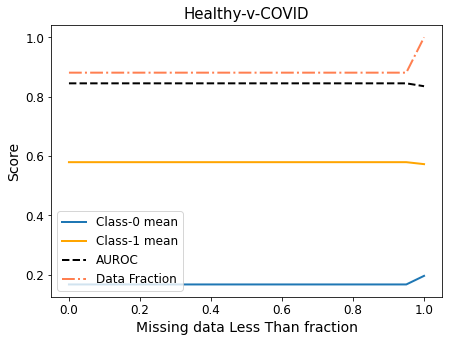

In [ ]:
fig = single_plot_missing_performance(y_val, yh_val, X_val, 'Healthy-v-COVID')
display(fig)

### Hyperparameter tune XGBoost

In [ ]:
space = []
for i in range(100):
    space.append({
               #'objective' : 'multi:softmax',
               'n_estimators' : np.random.choice(np.arange(10, 200, 10), 1)[0],
               #'eta' : np.random.choice(np.arange(0.01, 0.1, 0.02), 1)[0],
               'max_depth' : np.random.choice(np.arange(1, 10), 1)[0],
               #'min_child_weight' : np.random.choice(np.arange(1, 6, 1), 1)[0],
               'subsample' : np.random.choice(np.arange(0.5, 1, 0.05), 1)[0],
               'gamma' : np.random.choice(np.arange(0.5, 1, 0.05), 1)[0],
               'colsample_bytree' : np.random.choice(np.arange(0.5, 1, 0.05), 1)[0],
               #'silent' : 1,
               #'tree_method' : 'gpu_hist',
               'scale_pos_weight' : np.random.choice(np.arange(1, 10, 1), 1)[0], #add positive class weight up-scaling
               'seed' : np.random.choice(np.arange(1,10000),1)[0]
               })

In [ ]:
hypopt_HvC = run_xgb_hyperopt_2class(space, X_train[filter_train], y_train[filter_train],
                                     X_val[filter_val], y_val[filter_val])
hypopt_HvC.head(10)

,train_roc,val_roc,time_mins,n_estimators,max_depth,subsample,gamma,colsample_bytree,scale_pos_weight,seed
65,0.8541,0.8666,0.0004,50.0000,1.0000,0.7500,0.7500,0.5000,3.0000,1761.0000
89,0.8536,0.8657,0.0005,60.0000,1.0000,0.6000,0.6000,0.9000,7.0000,5105.0000
48,0.8721,0.8641,0.0006,40.0000,2.0000,0.9000,0.8000,0.8500,3.0000,6463.0000
56,0.8756,0.8631,0.0007,50.0000,2.0000,0.9500,0.7000,0.8500,4.0000,4500.0000
17,0.8587,0.8631,0.0009,110.0000,1.0000,0.8000,0.9000,0.7500,9.0000,6391.0000
38,0.8638,0.8627,0.0010,150.0000,1.0000,0.7000,0.8500,0.7000,2.0000,5212.0000
94,0.8641,0.8625,0.0011,160.0000,1.0000,0.9000,0.5500,0.5500,2.0000,5354.0000
4,0.8622,0.8623,0.0011,150.0000,1.0000,0.5500,0.9000,0.6000,5.0000,7289.0000
43,0.8615,0.8612,0.0012,120.0000,1.0000,0.8500,0.9000,0.7000,6.0000,3219.0000
39,0.8650,0.8612,0.0012,170.0000,1.0000,0.8000,0.5000,0.8000,8.0000,956.0000


### Pick the best hyperparameters and rerun classifier

In [ ]:
params = space[65]
classifier_HvC, _, yh_val = run_xgb_class2(XGBClassifier(**params), 
                                          X_train[filter_train], y_train[filter_train], 
                                          X_val[filter_val], y_val[filter_val])

Train ROC: 0.8541
Val ROC: 0.8666

#### Select thresholds for making predictions based on specificity cut-offs

In [ ]:
yh_val = classifier_HvC.predict_proba(X_val)
ROC_HvC_val, spec_thresh_HvC_val = get_specificity_threshold(y_val[filter_val],
                                                         yh_val[filter_val,1],
                                                         [0.95, 0.9]
                                                        )

95% Specifivity cutoff = 0.7792
 precision recall f1-score support

 0 0.83 0.95 0.89 388
 1 0.83 0.56 0.67 167

 accuracy 0.83 555
 macro avg 0.83 0.76 0.78 555
weighted avg 0.83 0.83 0.82 555

--------------------------------------------------
90% Specifivity cutoff = 0.7182
 precision recall f1-score support

 0 0.86 0.91 0.89 388
 1 0.76 0.66 0.71 167

 accuracy 0.84 555
 macro avg 0.81 0.79 0.80 555
weighted avg 0.83 0.84 0.83 555

--------------------------------------------------

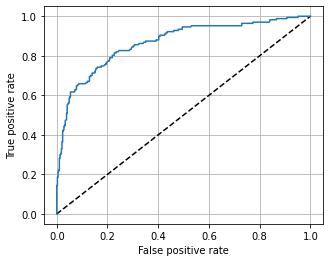

In [ ]:
plot_roc(ROC_HvC_val[0], ROC_HvC_val[1])

### Evaluate on Test set -- keep all days in predictions

In [ ]:
keep_test = (df_activity[split_col] == 'test')

X_test, y_test, filter_test = get_dataset(df_activity, keep_test, days_ago, feature_cols, label_col)

(2580, 20) (2580,)
Missing rows percent = 14.57%
/databricks/python/lib/python3.7/site-packages/pandas/core/generic.py:3878: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
 obj = obj._drop_axis(labels, axis, level=level, errors=errors)
 (labels, training_labels) count percent
0 -1 1320 51.1600
1 0 840 32.5600
2 1 420 16.2800
3 Total 2580 100.0000

Evaluate performance for selected specificity threshold

In [ ]:
specificity_threshold = 0.95
pred_HvC, plot_df_HvC = run_get_predictions(classifier_HvC, X_test, y_test, filter_test,
                                             df_activity.loc[:,idx['labels',:]], 
                                             specificity_threshold, 
                                             spec_thresh_HvC_val[specificity_threshold],
                                            ['H', 'C'], ['id_participant_external'], 
                                            'days_since_onset')
print(pred_HvC.shape)

N = 60
Cumulative recall shape= (86, 5)
Predictions shape= (2580, 11)
(2580, 11)

#### Look at cumulative recall at day 0, 3 and 6

In [ ]:
plot_df_HvC[plot_df_HvC.days_since_onset.isin([0,3,6])]

,days_since_onset,ILI_type,cumsum_spec95_HvC,count_spec95_HvC,recall_fraction,Type
28,0,2.0000,7.0000,29.0000,0.2414,"Flu, N=30"
31,3,2.0000,14.0000,30.0000,0.4667,"Flu, N=30"
34,6,2.0000,22.0000,30.0000,0.7333,"Flu, N=30"
71,0,3.0000,22.0000,30.0000,0.7333,"COVID, N=30"
74,3,3.0000,25.0000,30.0000,0.8333,"COVID, N=30"
77,6,3.0000,29.0000,30.0000,0.9667,"COVID, N=30"


In [ ]:
use_palette = [dict_hue[q] for q in [  'Flu', 'Covid']]
use_hue_order = [ 'Flu, N=30', 'COVID, N=30'] #list(pred_HvC.Type.unique())
print(use_hue_order)

['Flu, N=30', 'COVID, N=30']

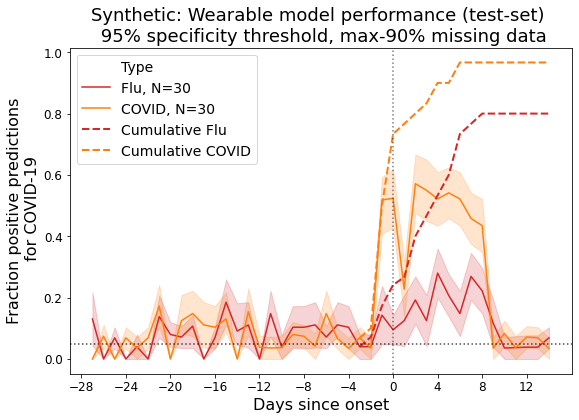

In [ ]:
fig, ax = plot_spec_recall_since_onset(pred_HvC, plot_df_HvC, specificity_threshold,
                                       'pred_spec95_HvC', 
                                        use_palette, use_hue_order,
                                        'Wearable model performance (test-set)',
                                        0.9, 'cumsum_spec95_HvC', 'count_spec95_HvC',
                                       'COVID-19', 'Synthetic', 'Type', 'days_since_onset')
display(fig)

### Feature importance

In [ ]:
get_feature_importance(classifier_HvC)

,feature_name,gain
0,3days_ago heart_rate__not_moving__max,174.8385
1,0days_ago heart_rate__perc_50th,108.5595
2,1days_ago heart_rate__stddev,105.8452
3,0days_ago heart_rate__stddev,64.9317
4,2days_ago heart_rate__stddev,49.7525
5,1days_ago heart_rate__not_moving__max,48.0518
6,1days_ago heart_rate__resting_heart_rate,44.1435
7,0days_ago heart_rate__resting_heart_rate,40.4743
8,1days_ago heart_rate__perc_50th,39.8212
9,2days_ago heart_rate__not_moving__max,39.3000


In [ ]:
### SAVE XGBOOST AS JSON
#classifier_HvC.save_model('model.json')